In [1]:
# Swin Transformer
# CT Kidney Dataset (Normal, Cyst, Tumor, Stone)

import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import timm
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.tensorboard import SummaryWriter
import os


2025-07-21 21:32:47.213637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753133567.559268      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753133567.657327      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import random
import numpy as np

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Transforms
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

Using device: cuda


In [4]:
# Dataset path
DATASET_PATH ='/kaggle/input/kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

# Load dataset
dataset = datasets.ImageFolder(root=DATASET_PATH, transform=transform_train)
print("Classes:", dataset.classes)

# Class distribution
labels = [sample[1] for sample in dataset.samples]
label_counts = Counter(labels)
print("Class distribution:", label_counts)

Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']
Class distribution: Counter({1: 5077, 0: 3709, 3: 2283, 2: 1377})


In [5]:
# Split dataset first
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply transform_test to val and test
val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

# Compute class weights ONLY for train_dataset
train_labels = [dataset[i][1] for i in train_dataset.indices]
train_counts = Counter(train_labels)
class_weights = [1.0 / train_counts[label] for label in train_labels]
sampler = WeightedRandomSampler(class_weights, num_samples=len(train_labels), replacement=True)


In [6]:

# Verify split sizes
print("Train Dataset Size:", len(train_dataset))
print("Validation Dataset Size:", len(val_dataset))
print("Test Dataset Size:", len(test_dataset))

Train Dataset Size: 8712
Validation Dataset Size: 2489
Test Dataset Size: 1245


In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [8]:
# Swin Transformer Model
class SwinClassifier(nn.Module):
    def __init__(self, num_classes):
        super(SwinClassifier, self).__init__()
        self.model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        return self.model(x)


In [9]:
# Initialize model
num_classes = len(dataset.classes)
model = SwinClassifier(num_classes=num_classes).to(device)

# Optimizer and loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
scaler = GradScaler()

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

/tmp/ipykernel_36/699395065.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [10]:
# Training function with AMP
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    best_val_loss = float('inf')
    patience = 5
    counter = 0
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

        train_loss = total_loss / len(train_loader.dataset)
        train_acc = 100. * correct / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        total_val_loss, val_correct = 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss = total_val_loss / len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        val_losses.append(val_loss)

        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")
        print(f"Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}")

        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Val", val_loss, epoch)
        writer.add_scalar("Accuracy/Train", train_acc, epoch)
        writer.add_scalar("Accuracy/Val", val_acc, epoch)
        writer.add_scalar("Precision/Val", precision, epoch)
        writer.add_scalar("Recall/Val", recall, epoch)
        writer.add_scalar("F1/Val", f1, epoch)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot loss
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title("Loss Curve")
    plt.show()

In [11]:
writer = SummaryWriter(log_dir="/kaggle/working/runs/swin_ct_kidney")

Epoch 1 Training:   0%|          | 0/273 [00:00<?, ?it/s]/tmp/ipykernel_36/3704179021.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 Validation: 100%|██████████| 78/78 [00:42<00:00,  1.86it/s]


Epoch 1: Train Loss=0.1720, Val Loss=0.0280, Train Acc=93.69%, Val Acc=99.24%
Precision=0.9918, Recall=0.9860, F1 Score=0.9889


Epoch 2 Training:   0%|          | 0/273 [00:00<?, ?it/s]/tmp/ipykernel_36/3704179021.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2 Validation: 100%|██████████| 78/78 [00:30<00:00,  2.52it/s]


Epoch 2: Train Loss=0.0499, Val Loss=0.1029, Train Acc=98.46%, Val Acc=96.58%
Precision=0.9725, Recall=0.9598, F1 Score=0.9650


Epoch 3 Training:   0%|          | 0/273 [00:00<?, ?it/s]/tmp/ipykernel_36/3704179021.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3 Validation: 100%|██████████| 78/78 [00:30<00:00,  2.56it/s]


Epoch 3: Train Loss=0.0235, Val Loss=0.0249, Train Acc=99.27%, Val Acc=99.32%
Precision=0.9928, Recall=0.9848, F1 Score=0.9886


Epoch 4 Training:   0%|          | 0/273 [00:00<?, ?it/s]/tmp/ipykernel_36/3704179021.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4 Validation: 100%|██████████| 78/78 [00:30<00:00,  2.55it/s]


Epoch 4: Train Loss=0.0186, Val Loss=0.0674, Train Acc=99.56%, Val Acc=98.11%
Precision=0.9638, Recall=0.9834, F1 Score=0.9721


Epoch 5 Training:   0%|          | 0/273 [00:00<?, ?it/s]/tmp/ipykernel_36/3704179021.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5 Validation: 100%|██████████| 78/78 [00:30<00:00,  2.54it/s]


Epoch 5: Train Loss=0.0103, Val Loss=0.0082, Train Acc=99.69%, Val Acc=99.84%
Precision=0.9975, Recall=0.9975, F1 Score=0.9975


Epoch 6 Training:   0%|          | 0/273 [00:00<?, ?it/s]/tmp/ipykernel_36/3704179021.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6 Validation: 100%|██████████| 78/78 [00:30<00:00,  2.54it/s]


Epoch 6: Train Loss=0.0217, Val Loss=0.0354, Train Acc=99.46%, Val Acc=98.96%
Precision=0.9856, Recall=0.9858, F1 Score=0.9856


Epoch 7 Training:   0%|          | 0/273 [00:00<?, ?it/s]/tmp/ipykernel_36/3704179021.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7 Validation: 100%|██████████| 78/78 [00:30<00:00,  2.52it/s]


Epoch 7: Train Loss=0.0309, Val Loss=0.0666, Train Acc=99.16%, Val Acc=98.11%
Precision=0.9848, Recall=0.9568, F1 Score=0.9686


Epoch 8 Training:   0%|          | 0/273 [00:00<?, ?it/s]/tmp/ipykernel_36/3704179021.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8 Validation: 100%|██████████| 78/78 [00:31<00:00,  2.50it/s]


Epoch 8: Train Loss=0.0106, Val Loss=0.0766, Train Acc=99.68%, Val Acc=98.23%
Precision=0.9859, Recall=0.9739, F1 Score=0.9794


Epoch 9 Training:   0%|          | 0/273 [00:00<?, ?it/s]/tmp/ipykernel_36/3704179021.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 9 Validation: 100%|██████████| 78/78 [00:30<00:00,  2.54it/s]


Epoch 9: Train Loss=0.0282, Val Loss=0.0124, Train Acc=99.21%, Val Acc=99.68%
Precision=0.9976, Recall=0.9929, F1 Score=0.9952


Epoch 10 Training:   0%|          | 0/273 [00:00<?, ?it/s]/tmp/ipykernel_36/3704179021.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 10 Validation: 100%|██████████| 78/78 [00:30<00:00,  2.53it/s]


Epoch 10: Train Loss=0.0226, Val Loss=0.0153, Train Acc=99.43%, Val Acc=99.44%
Precision=0.9936, Recall=0.9931, F1 Score=0.9933
Early stopping triggered.


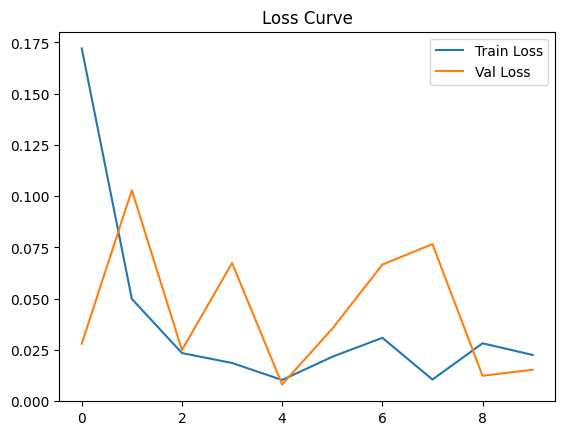

In [12]:
# Start training
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20)

In [13]:
writer.close()

In [14]:
%load_ext tensorboard
%tensorboard --logdir runs


<IPython.core.display.Javascript object>

In [15]:
 %reload_ext tensorboard

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"\nTest Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")

# Evaluate on test set
evaluate_model(model, test_loader)

Testing: 100%|██████████| 39/39 [00:21<00:00,  1.78it/s]


Test Accuracy: 0.9920
Test Precision: 0.9895
Test Recall: 0.9938
Test F1 Score: 0.9915


**SSL + Swin**

In [19]:
!git clone https://github.com/facebookresearch/dino.git
%cd dino



Cloning into 'dino'...
remote: Enumerating objects: 175, done.
remote: Total 175 (delta 0), reused 0 (delta 0), pack-reused 175 (from 1)
Receiving objects: 100% (175/175), 24.47 MiB | 36.90 MiB/s, done.
Resolving deltas: 100% (100/100), done.
/kaggle/working/dino/dino


In [21]:
!pip install timm torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [23]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from timm import create_model
from torchvision import datasets
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt


In [27]:
dinov2_vits14_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg', pretrained=True)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_reg4_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_reg4_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 171MB/s] 


In [31]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import AdamW
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tqdm import tqdm

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained DINOv2 model from torch.hub
dinov2_vits14_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg', pretrained=True)

# Replace the head of the model to match the number of classes in your dataset (adjust num_classes)
num_classes = 4  # Adjust based on your dataset (Cyst, Normal, Tumor, Stone)
in_features = dinov2_vits14_reg.embed_dim  # The embedding dimension from the model
dinov2_vits14_reg.head = nn.Linear(in_features, num_classes)  # Replace the head

# Move the model to the correct device
dinov2_vits14_reg = dinov2_vits14_reg.to(device)

# Freeze the backbone and only train the head (linear probe)
for param in dinov2_vits14_reg.parameters():
    param.requires_grad = False

# Unfreeze the head layers for fine-tuning
for param in dinov2_vits14_reg.head.parameters():
    param.requires_grad = True



Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [33]:
# Define optimizer and loss function
optimizer = AdamW(dinov2_vits14_reg.head.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Set up data transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load your dataset (adjust the path accordingly)
DATASET_PATH = '/kaggle/input/kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'  # Adjust the path to your dataset
dataset = datasets.ImageFolder(root=DATASET_PATH, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Fine-tuning loop
def fine_tune_model(model, train_loader, criterion, optimizer, epochs=20):
    train_losses = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

        train_loss = total_loss / len(train_loader.dataset)
        train_acc = 100. * correct / len(train_loader.dataset)
        train_losses.append(train_loss)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Accuracy={train_acc:.2f}%")

    return train_losses




In [ ]:
# Start fine-tuning
train_losses = fine_tune_model(dinov2_vits14_reg, train_loader, criterion, optimizer, epochs=20)

# Save the fine-tuned model
torch.save(dinov2_vits14_reg.state_dict(), 'fine_tuned_dinov2.pth')

# Now evaluate the model on a test set
test_dataset = datasets.ImageFolder(root='/path_to_test_dataset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"\nTest Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")

# Evaluate the fine-tuned model
evaluate_model(dinov2_vits14_reg, test_loader)

# Visualization of the training loss curve
plt.plot(train_losses, label='Train Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

# If you want to compare with supervised baseline (you need baseline metrics)
supervised_precision = 0.89  # Example
supervised_recall = 0.90     # Example
supervised_f1 = 0.89        # Example

ssl_metrics = [precision, recall, f1]
supervised_metrics = [supervised_precision, supervised_recall, supervised_f1]

# Compare precision, recall, and F1 scores
metrics = ['Precision', 'Recall', 'F1']
plt.bar(metrics, supervised_metrics, alpha=0.6, label="Supervised")
plt.bar(metrics, ssl_metrics, alpha=0.6, label="SSL")
plt.legend()
plt.title("Metrics Comparison")
plt.show()